## Import the necessary libraries

In [ ]:
!wget https://drive.google.com/uc?export=download&id=173tvWt-qPyAqZJc1KoBiUHgoSg6nLUtT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

2022-12-12 19:58:06.558670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 19:58:06.890767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-12 19:58:06.890790: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-12 19:58:08.428374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

## Investigate the dataset

In [2]:
random_seed = 69
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [3]:
df

,DATUM,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1766,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1766,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1766,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1766,1,13.5,90.0,0.8,9.4,104


/tmp/ipykernel_4659/2793083954.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


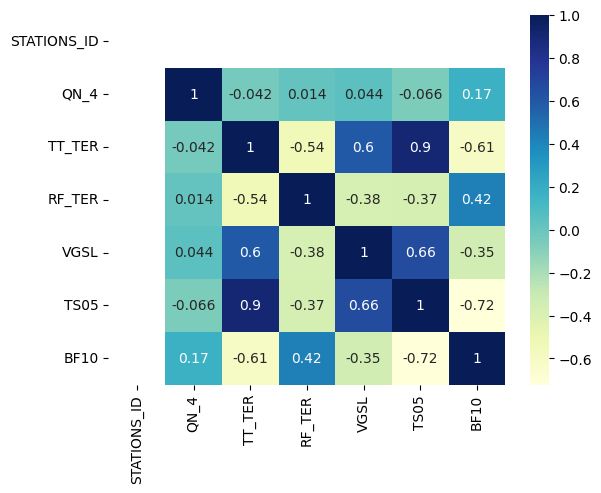

In [4]:
# DF Correletion
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [5]:
print(df.STATIONS_ID.unique())
print(df.QN_4.unique())

[1766]
[10  3  1]


In [6]:
df2 = df.copy()
df2 = df2[["DATUM", "BF10"]]
df2.DATUM = df2.DATUM.astype('datetime64[ns]')
df2 = df2.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
df2['BF10'] = df2["BF10"].astype('int32')
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   BF10    11323 non-null  int32
dtypes: int32(1)
memory usage: 132.7 KB


In [7]:
df2

,BF10
DATUM,
1991-01-01,102
1991-01-02,110
1991-01-03,110
1991-01-04,106
1991-01-05,109
...,...
2021-12-27,97
2021-12-28,104
2021-12-29,107


In [8]:
df2.describe()

,BF10
count,11323.000000
mean,71.004063
std,37.056605
min,0.000000
25%,41.000000
50%,88.000000
75%,102.000000
max,111.000000


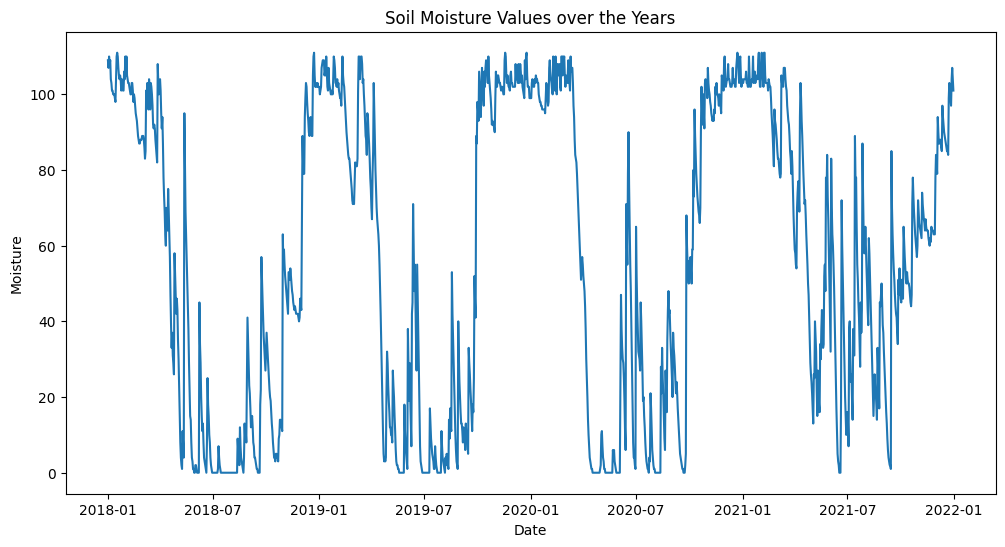

In [9]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(df2['BF10']['2018':])

In [10]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
        
check_stationarity(df2)

The series is stationary


/tmp/ipykernel_4659/2753353209.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)


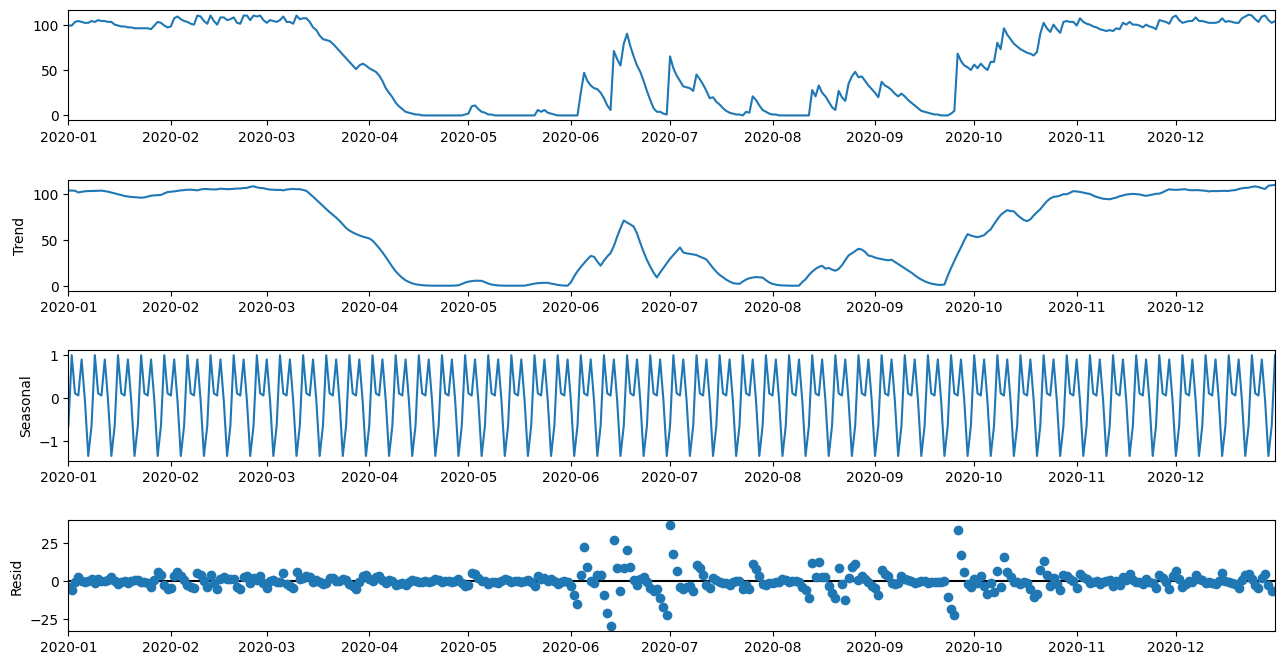

In [11]:
analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)
    
fig = analysis.plot()
fig.set_size_inches(14, 7)
plt.show()

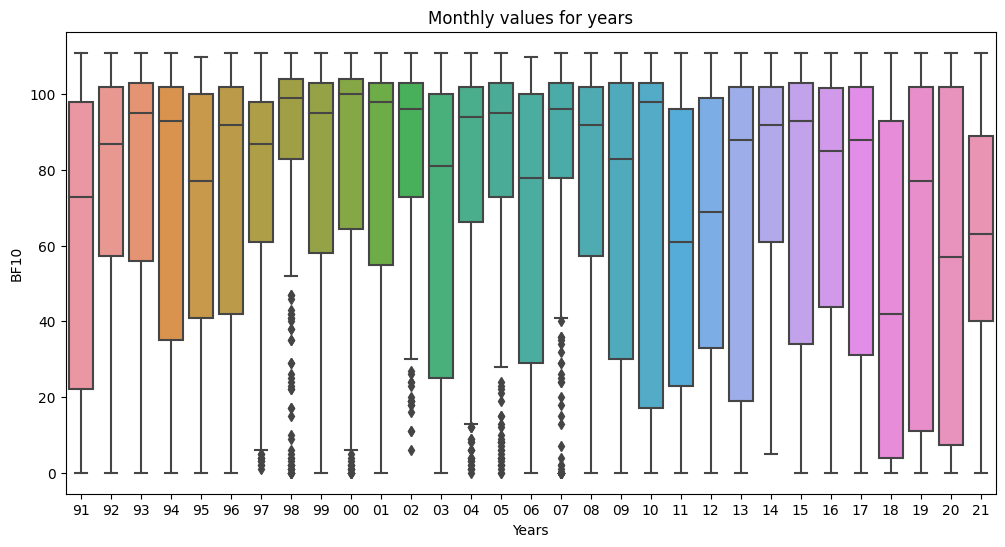

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=df2.index.strftime("%y"), y=df2["BF10"])
plt.title("Monthly values for years")
plt.xlabel("Years")
plt.show()

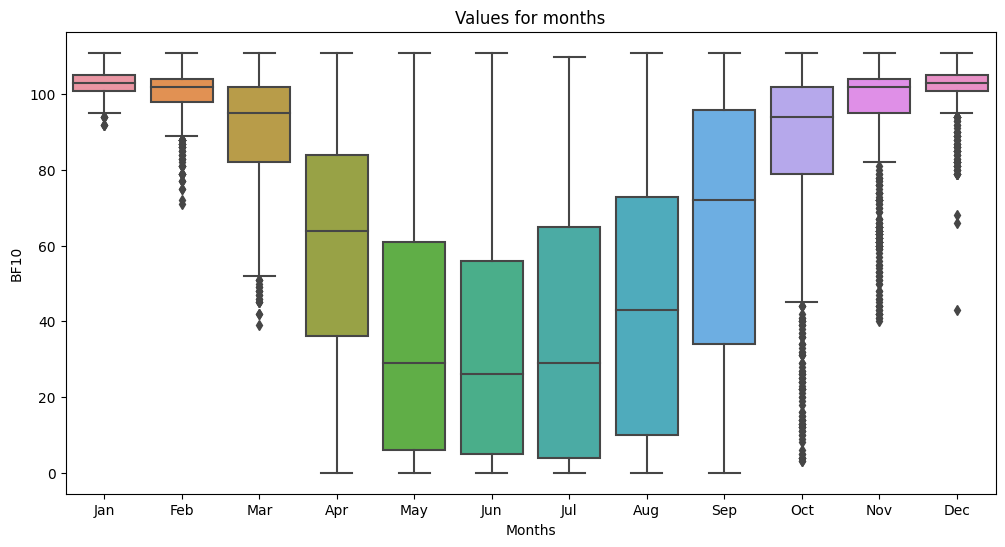

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=df2.index.strftime("%b"), y=df2["BF10"], ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

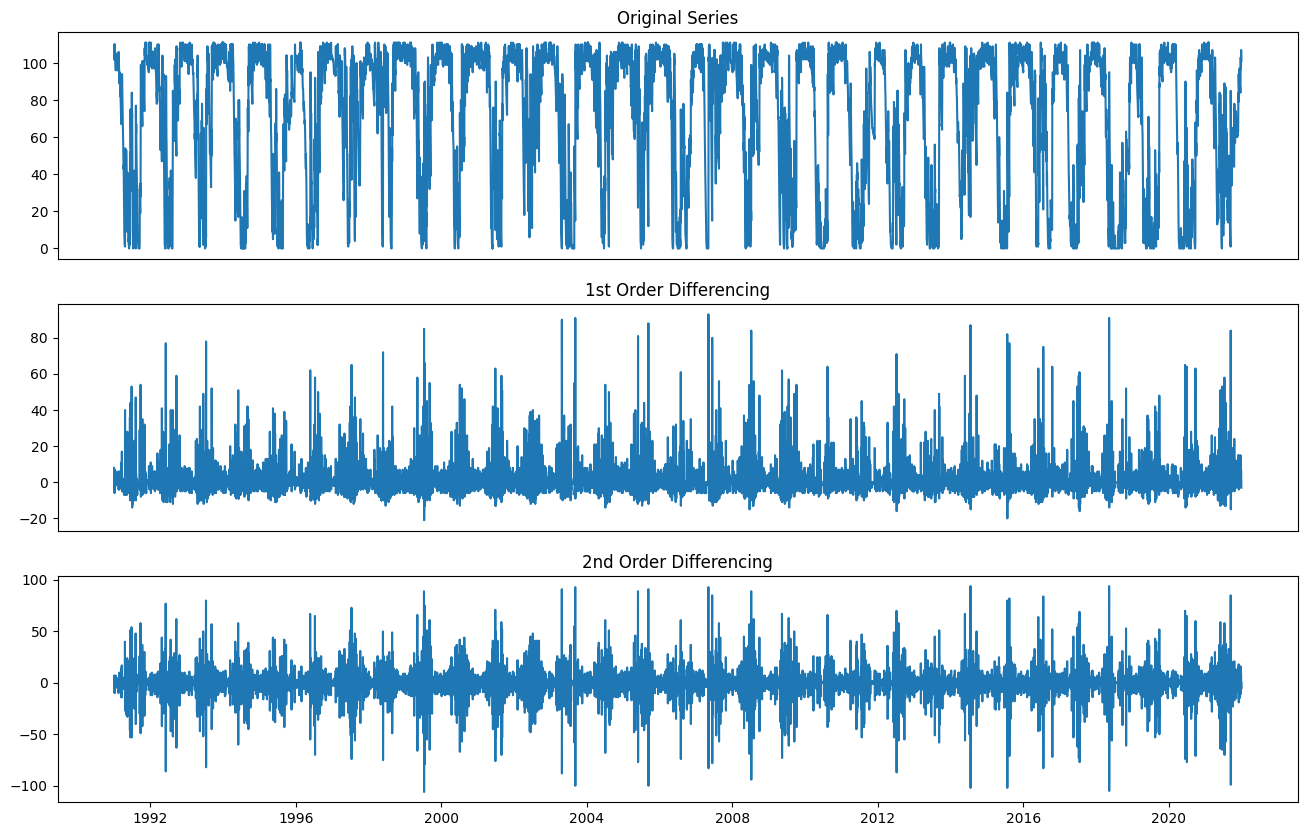

In [14]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 10))
ax1.plot(df2.BF10)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df2.BF10.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df2.BF10.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

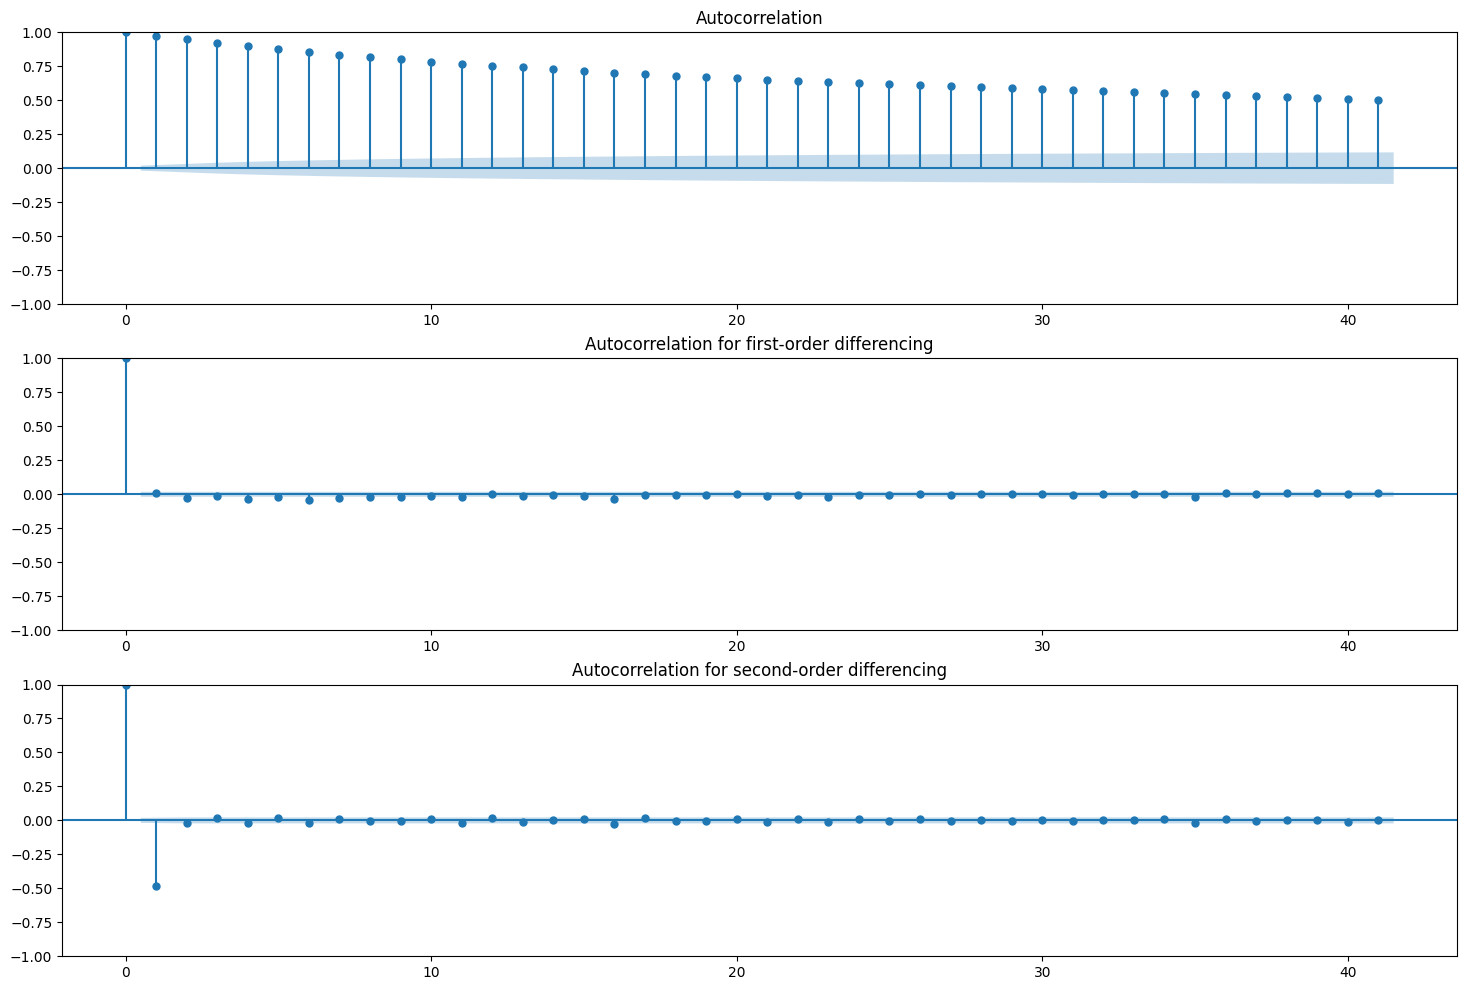

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))
_ = plot_acf(df2.BF10, ax=ax1)
_ = plot_acf(df2.BF10.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(df2.BF10.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

/home/robertrompf/Documents/coding/Machine_Learning_and_Deep_Learning/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation coefficient')

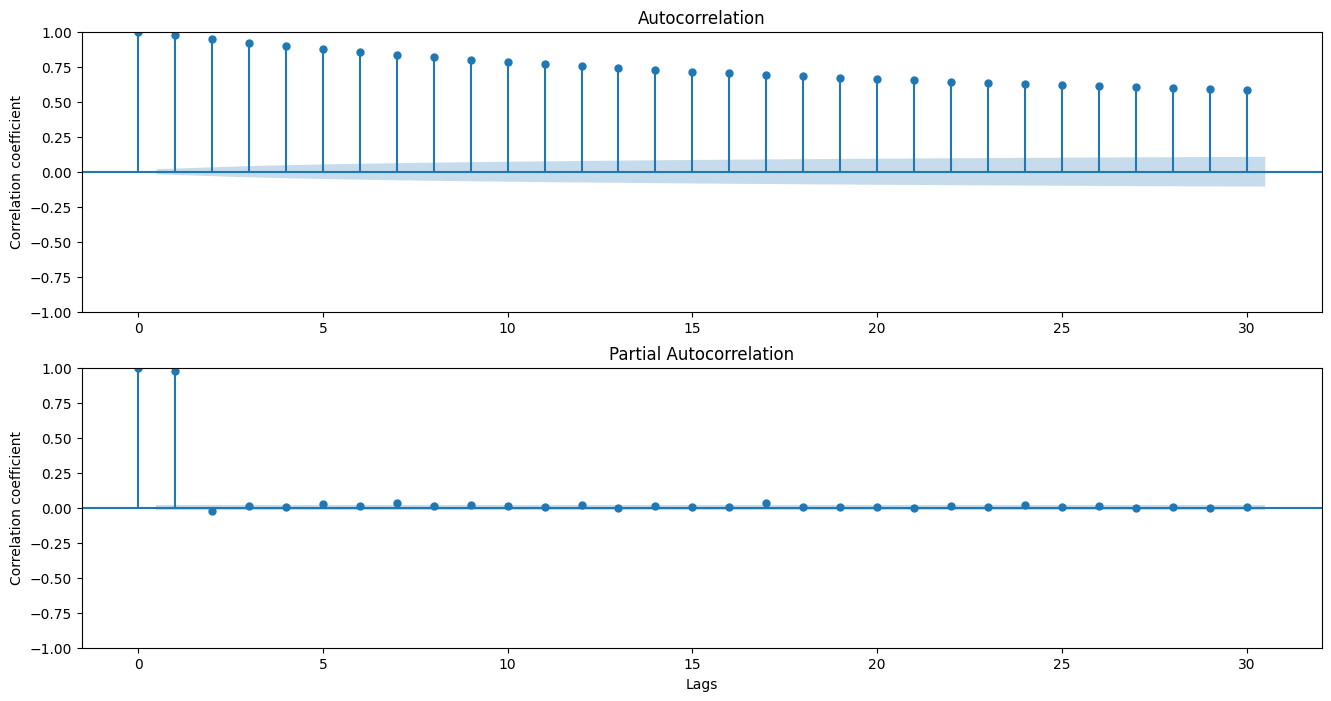

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
ax1.set_title('Autocorrelation')
_ = plot_acf(df2['BF10'], lags=30, ax = ax1)
ax2.set_title('Partial Autocorrelation')
_ = plot_pacf(df2['BF10'], lags=30, ax = ax2)
ax1.set_ylabel("Correlation coefficient")
ax2.set_xlabel("Lags")
ax2.set_ylabel("Correlation coefficient")

## Linear Regression and Random Forest Regressor

In [17]:
reindexed_df = df.copy()
reindexed_df = reindexed_df[["DATUM", "BF10", "RF_TER"]]
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
reindexed_df['BF10'] = reindexed_df["BF10"].astype('int32')
reindexed_df['RF_TER'] = reindexed_df["RF_TER"].astype('float32')
reindexed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BF10    11323 non-null  int32  
 1   RF_TER  11323 non-null  float32
dtypes: float32(1), int32(1)
memory usage: 176.9 KB


In [51]:
X = reindexed_df[["RF_TER"]]

y = reindexed_df[['BF10']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.10, random_state=random_seed)

In [52]:
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

/tmp/ipykernel_4659/4150774867.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train, y_train)


In [53]:
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

predictions = pd.DataFrame(lr_pred, index = y_test.index, columns = ['Prediction_Linear'])
predictions['Prediction_Forest'] = forest_pred
predictions['Actuals'] = np.array(y_test)

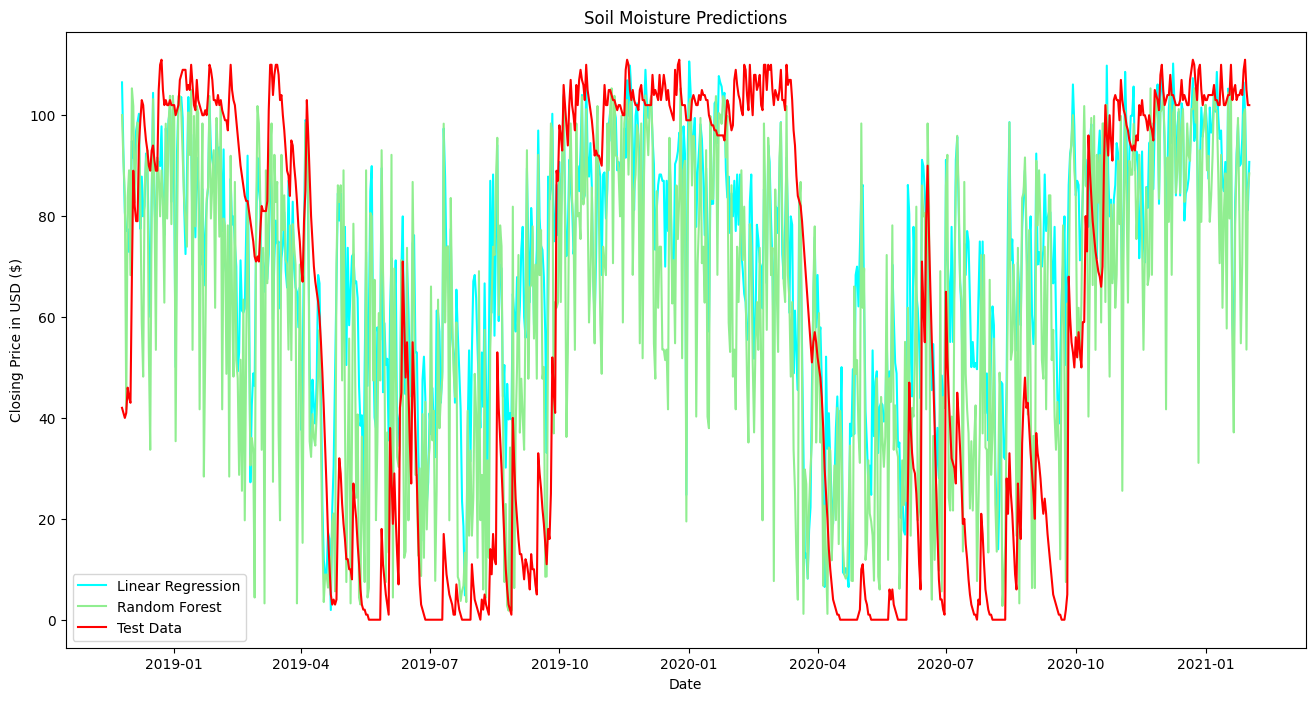

In [54]:
plt.figure(figsize=(16,8))
plt.title('Soil Moisture Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price in USD ($)')


plt.plot(predictions['Prediction_Linear'][:800], label = 'Linear Regression', color = 'cyan')
plt.plot(predictions['Prediction_Forest'][:800], label = "Random Forest", color = 'lightgreen')
plt.plot(predictions['Actuals'][:800], label = 'Test Data', color = 'red')
plt.legend()
plt.show()

In [55]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 27.3437
Mean Squared Error: 1102.2819
Root Mean Squared Error: 33.2006
(R^2) Score: 0.2903
Train Score: 36.08% and Test Score: 29.03% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 27.5911
Mean Squared Error: 1185.3964
Root Mean Squared Error: 34.4296
(R^2) Score: 0.2368
Train Score: 41.80% and Test Score: 23.68% using Random Forest Regressor.


In [ ]:
FORECAST = 30
df2['Prediction'] = df2[['BF10']].shift(-FORECAST)

In [ ]:
# Create X and y variables shifted by the number of days we want to predict.
X = df2[['BF10']][:-FORECAST]
y = df2[['Prediction']][:-FORECAST]

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)
y = sc.fit_transform(y)

# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (9034, 1) 
 (9034, 1) 
 (2259, 1) 
 (2259, 1)


In [ ]:
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

/tmp/ipykernel_4659/4150774867.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest = RandomForestRegressor().fit(X_train, y_train)


In [ ]:
y_test

array([[0.85585586],
       [0.84684685],
       [0.83783784],
       ...,
       [0.96396396],
       [0.93693694],
       [0.90990991]])

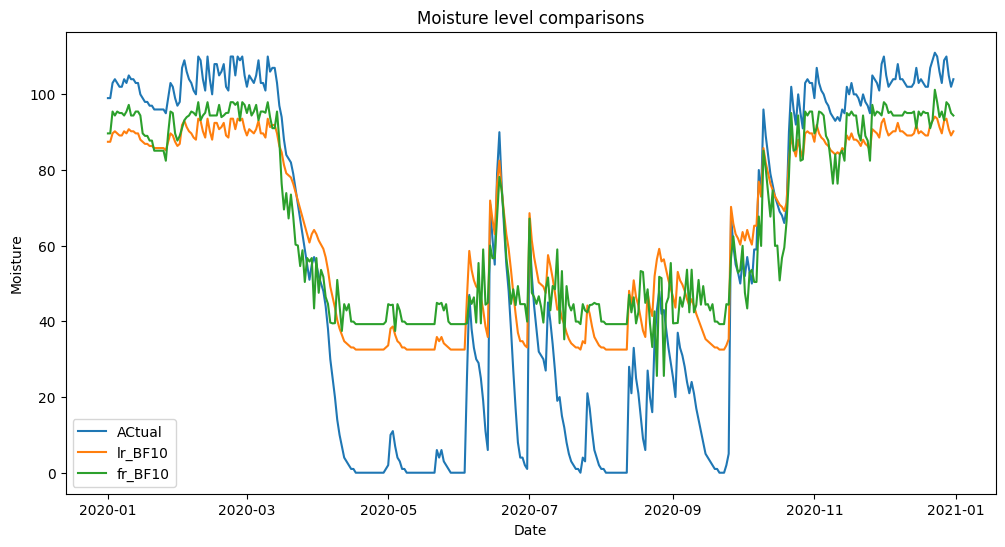

In [ ]:
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

forest_pred = sc.inverse_transform(forest_pred.reshape(-1, 1))
lr_pred = sc.inverse_transform(lr_pred.reshape(-1, 1))

prediction = pd.DataFrame(lr_pred, index=df2[9034+FORECAST:].index, columns = ['lr_BF10'])
prediction['fr_BF10'] = forest_pred
prediction['Actuals'] = sc.inverse_transform(y_test.reshape(-1, 1))

prediction['lr_BF10'] = prediction[['lr_BF10']].shift(-FORECAST)
prediction['fr_BF10'] = prediction[['fr_BF10']].shift(-FORECAST)

plt.figure(figsize=(12,6))
plt.plot(prediction['Actuals']['2020'], label = 'ACtual')
plt.plot(prediction['lr_BF10']['2020'], label = 'lr_BF10')
plt.plot(prediction['fr_BF10']['2020'], label = 'fr_BF10')
plt.legend()
plt.title('Moisture level comparisons')  
plt.ylabel("Moisture")
plt.xlabel('Date')
plt.show()

In [ ]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 66.4651
Mean Squared Error: 4899.7425
Root Mean Squared Error: 69.9982
(R^2) Score: -37818.3451
Train Score: 30.80% and Test Score: 39.10% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 66.8539
Mean Squared Error: 4965.738
Root Mean Squared Error: 70.468
(R^2) Score: -38327.7409
Train Score: 35.35% and Test Score: 40.25% using Random Forest Regressor.


In [62]:
train_data, test_data = train_test_split(df2, shuffle=False, test_size=0.2, random_state=42)

In [63]:
start = len(train_data)
end = len(train_data) + len(test_data) -1

In [64]:
train_model = ARIMA(train_data['BF10'], order=(1,1,1)).fit()
predictions = train_model.predict(start = start-365, end = end)
predictions

2014-10-20    106.203547
2014-10-21    102.799919
2014-10-22    107.219461
2014-10-23    105.832722
2014-10-24    102.024257
                 ...    
2021-12-27    102.966065
2021-12-28    102.966065
2021-12-29    102.966065
2021-12-30    102.966065
2021-12-31    102.966065
Freq: D, Name: predicted_mean, Length: 2630, dtype: float64

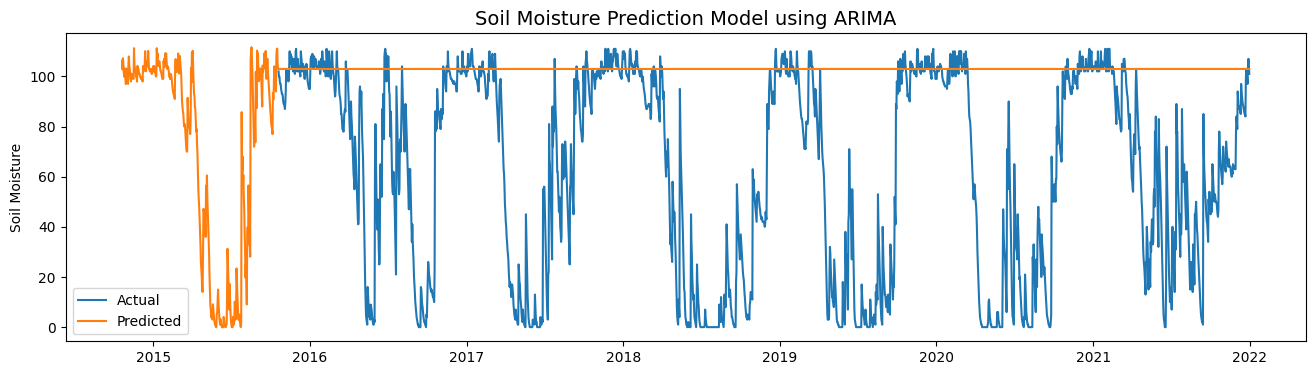

In [65]:
plt.figure(figsize=(16,4))
plt.plot(test_data['BF10'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Soil Moisture Prediction Model using ARIMA', fontsize=14)
plt.ylabel('Soil Moisture')
plt.legend()

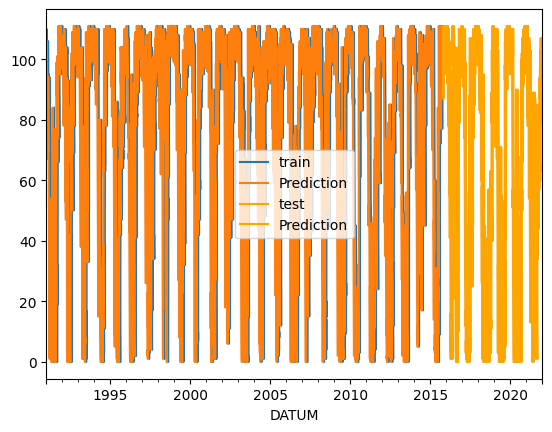

In [66]:
ax = train_data.rename({"BF10":"train"}, axis=1).plot()
test_data.rename({"BF10":"test"}, axis=1).plot(ax=ax, c="orange");

In [67]:
for i in [1,2, 9, 12]:
  df2[f"prev{i}th_month"] = df2["BF10"].shift(i).bfill() ## we only backfill train data
train_data, test_data = train_test_split(df2, test_size=0.1, shuffle=False)  

In [68]:
xcols = [c for c in df2.columns if c.startswith("prev")]
xcols

['prev1th_month', 'prev2th_month', 'prev9th_month', 'prev12th_month']

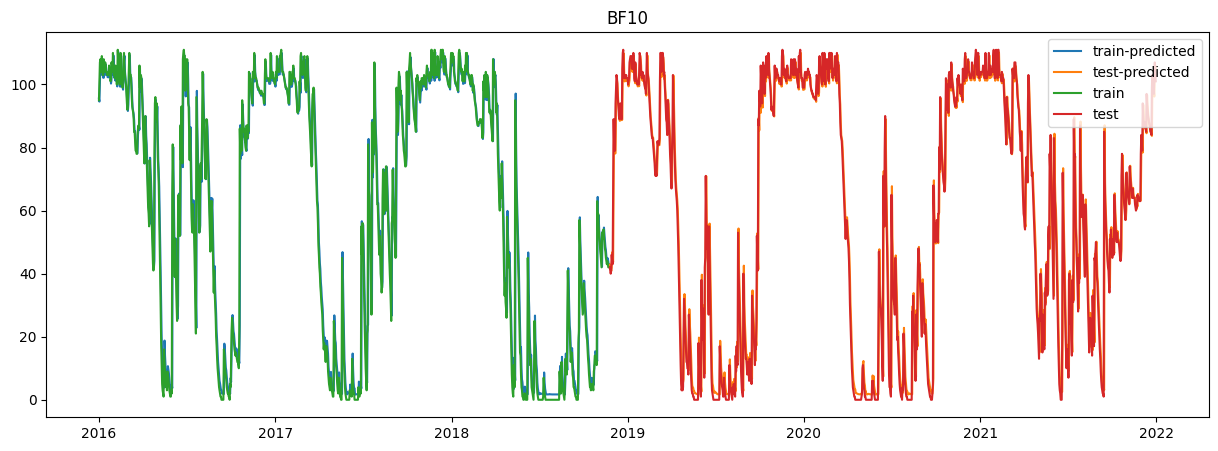

In [69]:
linear = LinearRegression()
linear.fit(train_data[xcols],train_data["BF10"])#

lr_pred = linear.predict(train_data[xcols])
lr_pred = pd.Series(lr_pred)
lr_pred.index = train_data.index

prediction2 = linear.predict(test_data[xcols])
prediction2 = pd.Series(prediction2)
prediction2.index = test_data.index

plt.figure(figsize=(15,5))

plt.plot(lr_pred['2016':], label="train-predicted")
plt.plot(prediction2, label="test-predicted")

plt.plot(train_data["BF10"]['2016':], label="train")

plt.plot(test_data["BF10"], label="test")

plt.title("BF10")
plt.legend()

plt.show()

In [70]:
history = [x for x in list(train_data["BF10"].values.astype("int32"))]
predictions = list()

print("Predicting forward with ARIMA:\n")

# We iterate through the test set step by step
# Yes, test set. This can be undestood as an on-line learning scenario, for each datapoint 
for t in range(len(list(test_data["BF10"].values.astype("int32")))):
    # Initialize model
    # It is important to note, that ARIMA is parametrized by hand, in our case we use `ARIMA(..., order=(5,1,0))` which means 5 autoregressive components, first difference and no moving averages for illustration. In choosing AR components it is instructive to look at the fitted model (in our code, `model_fit`), which stores goodness of fit mertics, but ACF and PACF is equally informative
    model = ARIMA(history, order=(5,1,0))

    # Do Scikit-like mode.fit(), disp=0 so that no bullshit output on stdout, please! 
    model_fit = model.fit()

    # Forecast one time period ahead
    output = model_fit.forecast()
    # Collect it
    yhat = output[0]
    predictions.append(yhat)
    
    #Step one further in time
    obs = list(test_data["BF10"].values.astype("int32"))[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))



Predicting forward with ARIMA:

predicted=42.039248, expected=42.000000
predicted=42.057296, expected=41.000000
predicted=41.004879, expected=40.000000
predicted=40.008159, expected=41.000000
predicted=41.054542, expected=46.000000
predicted=46.104332, expected=44.000000
predicted=43.901731, expected=43.000000
predicted=42.914570, expected=68.000000
predicted=68.188306, expected=89.000000
predicted=88.756044, expected=82.000000
predicted=81.037928, expected=79.000000
predicted=77.769481, expected=79.000000
predicted=77.926308, expected=94.000000
predicted=94.157805, expected=99.000000
predicted=98.976665, expected=103.000000
predicted=102.713355, expected=102.000000
predicted=101.229603, expected=98.000000
predicted=97.428537, expected=95.000000
predicted=94.822438, expected=93.000000
predicted=93.080855, expected=90.000000
predicted=90.229559, expected=89.000000
predicted=89.277112, expected=93.000000
predicted=93.267567, expected=94.000000
predicted=94.095270, expected=91.000000
pred


Mean abs error: 4.564054858487365
Explained variance: 0.9545448090565626


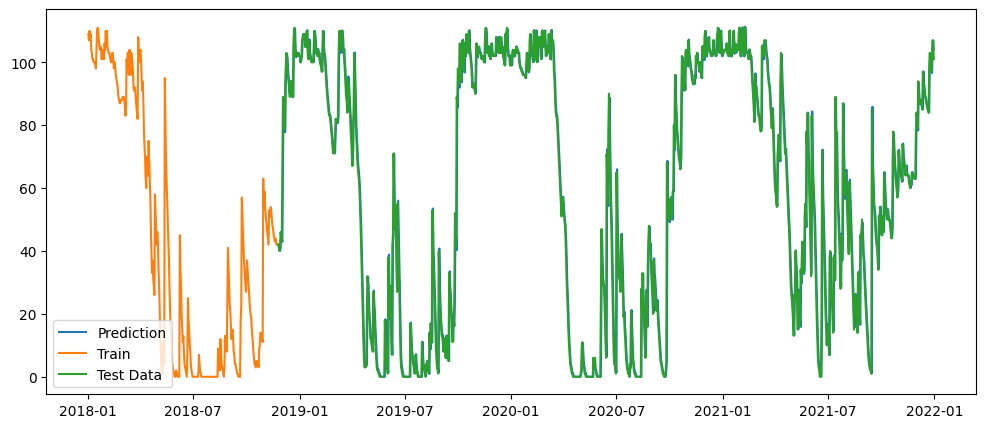

In [71]:
# Do some error analysis
    
errors = np.array(test_data["BF10"].values)-np.array(predictions)

print()
print("Mean abs error:",metrics.mean_absolute_error(test_data["BF10"].values,predictions))
print("Explained variance:",metrics.explained_variance_score(test_data["BF10"].values,predictions))

predictions = pd.Series(predictions)
predictions.index =test_data.index    

fig, ax = plt.subplots(figsize=(12,5))
plt.plot(predictions, label="Prediction")

plt.plot(train_data["BF10"]['2018':], label="Train")

plt.plot(test_data["BF10"], label="Test Data")
plt.legend()
plt.show()

In [72]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                11322
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -40191.196
Date:                Mon, 12 Dec 2022   AIC                          80394.391
Time:                        21:18:19   BIC                          80438.398
Sample:                             0   HQIC                         80409.196
                              - 11322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0078      0.007      1.098      0.272      -0.006       0.022
ar.L2         -0.0258      0.008     -3.100      0.002      -0.042      -0.009
ar.L3         -0.0157      0.008     -1.917      0.0

In [ ]:
train_data, test_data = train_test_split(reindexed_df, shuffle=False, test_size=0.2, random_state=42)
train_dat

In [77]:
import pmdarima as pm

arima_model = pm.auto_arima(train_data, m=12)
arima_model.summary()

ValueError: y should be a 1d array, got an array of shape (9058, 6) instead.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = [x for x in list(train_data["BF10"].values.astype("int32"))]
predictions = list()

print("Predicting forward with ARIMA:\n")

# We iterate through the test set step by step
# Yes, test set. This can be undestood as an on-line learning scenario, for each datapoint 
for t in range(len(list(test_data["BF10"].values.astype("int32")))):
    # Initialize model
    # It is important to note, that ARIMA is parametrized by hand, in our case we use `ARIMA(..., order=(5,1,0))` which means 5 autoregressive components, first difference and no moving averages for illustration. In choosing AR components it is instructive to look at the fitted model (in our code, `model_fit`), which stores goodness of fit mertics, but ACF and PACF is equally informative
    model = SARIMAX(history, order=(2,1,2))

    # Do Scikit-like mode.fit(), disp=0 so that no bullshit output on stdout, please! 
    model_fit = model.fit()

    # Forecast one time period ahead
    output = model_fit.forecast()
    # Collect it
    yhat = output[0]
    predictions.append(yhat)
    
    #Step one further in time
    obs = list(test_data["BF10"].values.astype("int32"))[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df2["BF10"]['2018':], label="Actual")
plt.plot(predictions['2018':], label="Predicted")
plt.title('Soil Moisture Prediction Model using SARIMAX')
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [83]:
df2 = df2.drop(columns=['prev1th_month', 'prev2th_month', 'prev9th_month', 'prev12th_month'])

In [92]:
FORECAST = -30
df2['Prediction'] = df2[['BF10']].shift(-FORECAST)
df2

,BF10,Prediction
DATUM,,
1991-01-01,102,NaN
1991-01-02,110,NaN
1991-01-03,110,NaN
1991-01-04,106,NaN
1991-01-05,109,NaN
...,...,...
2021-12-27,97,63.0
2021-12-28,104,63.0
2021-12-29,107,63.0


In [94]:
# Create X and y variables shifted by the number of days we want to predict.
X = df2[['BF10']]
y = df2[['Prediction']]

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)
y = sc.fit_transform(y)

# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)

 (9058, 1) 
 (9058, 1) 
 (2265, 1) 
 (2265, 1)


In [95]:
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

ValueError: Input y contains NaN.

In [89]:
y_test

array([[0.85585586],
       [0.84684685],
       [0.83783784],
       ...,
       [0.96396396],
       [0.93693694],
       [0.90990991]])

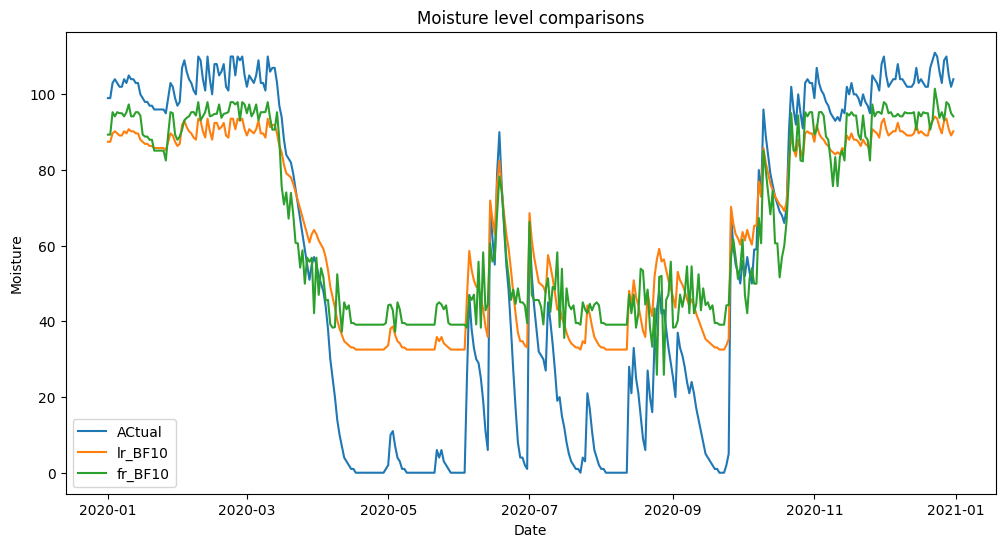

In [91]:
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

forest_pred = sc.inverse_transform(forest_pred.reshape(-1, 1))
lr_pred = sc.inverse_transform(lr_pred.reshape(-1, 1))

prediction = pd.DataFrame(lr_pred, index=df2[9034+FORECAST:].index, columns = ['lr_BF10'])
prediction['fr_BF10'] = forest_pred
prediction['Actuals'] = sc.inverse_transform(y_test.reshape(-1, 1))

prediction['lr_BF10'] = prediction[['lr_BF10']].shift(-FORECAST)
prediction['fr_BF10'] = prediction[['fr_BF10']].shift(-FORECAST)

plt.figure(figsize=(12,6))
plt.plot(prediction['Actuals']['2020'], label = 'Actual')
plt.plot(prediction['lr_BF10']['2020'], label = 'lr_BF10')
plt.plot(prediction['fr_BF10']['2020'], label = 'fr_BF10')
plt.legend()
plt.title('Moisture level comparisons')  
plt.ylabel("Moisture")
plt.xlabel('Date')
plt.show()

In [61]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')

LINEAR REGRESSION: 
-------------------------------------------
Mean Absolute Error: 66.4651
Mean Squared Error: 4899.7425
Root Mean Squared Error: 69.9982
(R^2) Score: -37818.3451
Train Score: 30.80% and Test Score: 39.10% using Linear Regression.

RANDOM FOREST REGRESSOR: 
-------------------------------------------
Mean Absolute Error: 66.8539
Mean Squared Error: 4965.738
Root Mean Squared Error: 70.468
(R^2) Score: -38327.7409
Train Score: 35.35% and Test Score: 40.25% using Random Forest Regressor.
